In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Data Loading - tf data input pipeline
* tf_dataset data structure
* ETL

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = r"C:\Users\otien\project\training\potato_diseases",
    labels = "inferred",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Early Blight', 'Healthy', 'Late Blight']

In [5]:
len(dataset)

68

* length is 68 because out of the 2152 images, divided by 32 images for each batch gives 68

(256, 256, 3)


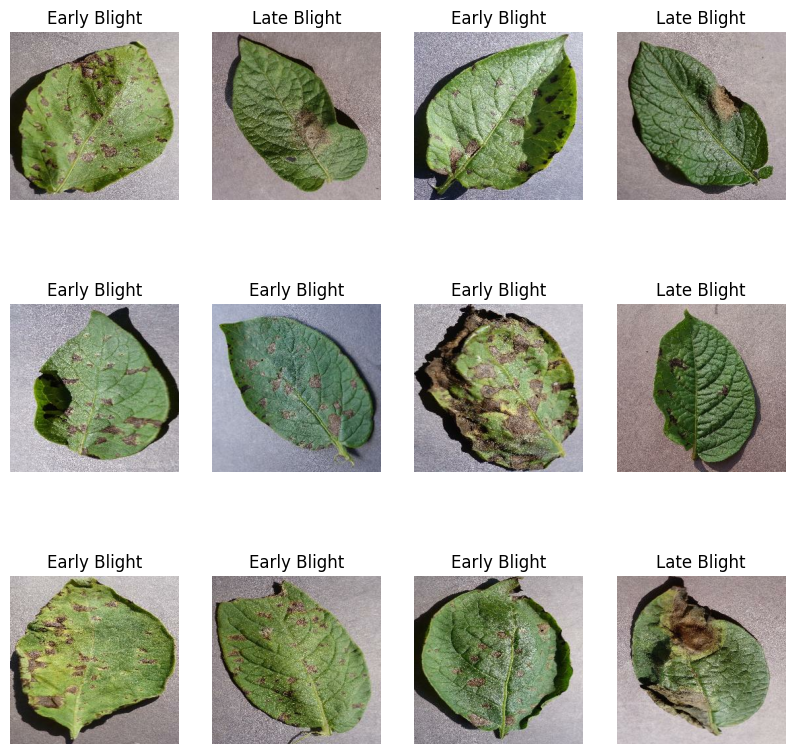

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Splitting the Dataset int train, test and validation
* 80% as training data
* #### Remaining 20% split into:
* 10% test data
* 10% validation

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
remaining_ds = dataset.skip(54)
len(remaining_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = remaining_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = remaining_ds.skip(6)
len(test_ds)

8

#### Python function to split the data

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)
    


    
    return train_ds, val_ds, test_ds

#### Calling the function on the dataset

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)


54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

### Caching
* Caching is a technique used to store data temporarily for quicker access during subsequent reads.

### Prefetching
* Prefetching loads data for the next training step while the current step is still executing. This leverages CPU-GPU parallelism to hide data loading latency.

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Rescaling the image size

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)  
])

#### Data augmentation
* to make the model robust

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)  
])

### Model Training
### Convolutional Neural Network (CNN) model

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = "softmax") #softmax normalizes the probability of the classes
])

model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

#### Model compiling, optimization, loss function, metrics, model fitting ...

In [24]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds   
)

Epoch 1/40
54/54 [==============================] - 214s 4s/step - loss: 0.8414 - accuracy: 0.5631 - val_loss: 0.6516 - val_accuracy: 0.6927
Epoch 2/40
54/54 [==============================] - 164s 3s/step - loss: 0.6076 - accuracy: 0.7188 - val_loss: 0.4363 - val_accuracy: 0.7969
Epoch 3/40
54/54 [==============================] - 161s 3s/step - loss: 0.4007 - accuracy: 0.8281 - val_loss: 0.4216 - val_accuracy: 0.7917
Epoch 4/40
54/54 [==============================] - 164s 3s/step - loss: 0.2437 - accuracy: 0.8941 - val_loss: 0.1724 - val_accuracy: 0.9219
Epoch 5/40
54/54 [==============================] - 169s 3s/step - loss: 0.2066 - accuracy: 0.9167 - val_loss: 0.5040 - val_accuracy: 0.8073
Epoch 6/40
54/54 [==============================] - 166s 3s/step - loss: 0.2084 - accuracy: 0.9230 - val_loss: 0.1605 - val_accuracy: 0.9635
Epoch 7/40
54/54 [==============================] - 164s 3s/step - loss: 0.1558 - accuracy: 0.9369 - val_loss: 0.1926 - val_accuracy: 0.9219
Epoch 8/40
54

#### Modle Testing on a Test Dataset (test_ds)

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 746ms/step - loss: 0.0248 - accuracy: 0.9883


In [29]:
scores

[0.024828914552927017, 0.98828125]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Plotting model history keys

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

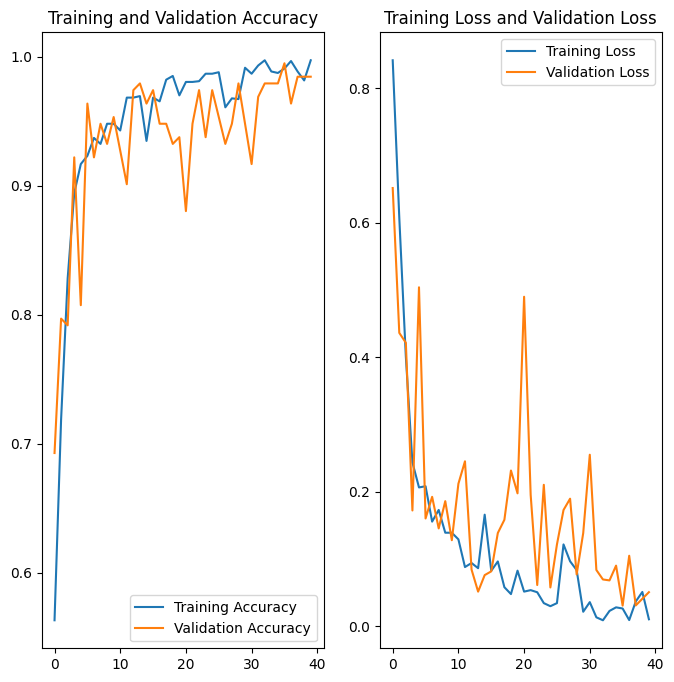

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss")

plt.show()

#### Making predictions

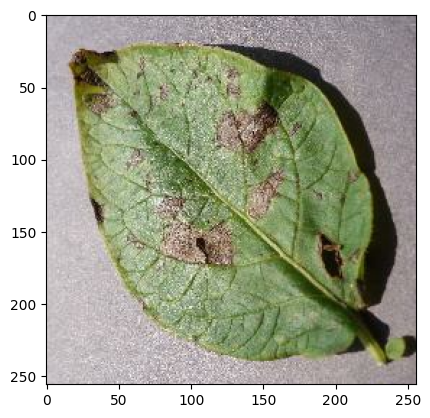

In [35]:
for image_batch, label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))

First image to predict
First image's label: Early Blight
1/1 [==============================] - 1s 1s/step
Predicted label: Early Blight


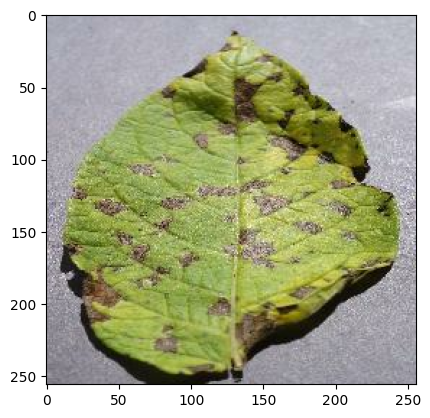

In [36]:
import numpy as np

for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("First image's label:", class_names[first_label])
    #making predictions
    batch_prediction = model.predict(image_batch) #batch prediction
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    

#### Confidence

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # creates a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return(predicted_class, confidence)
    


#### Running the prediction on the entire batch

1/1 [==============================] - 0s 63ms/step


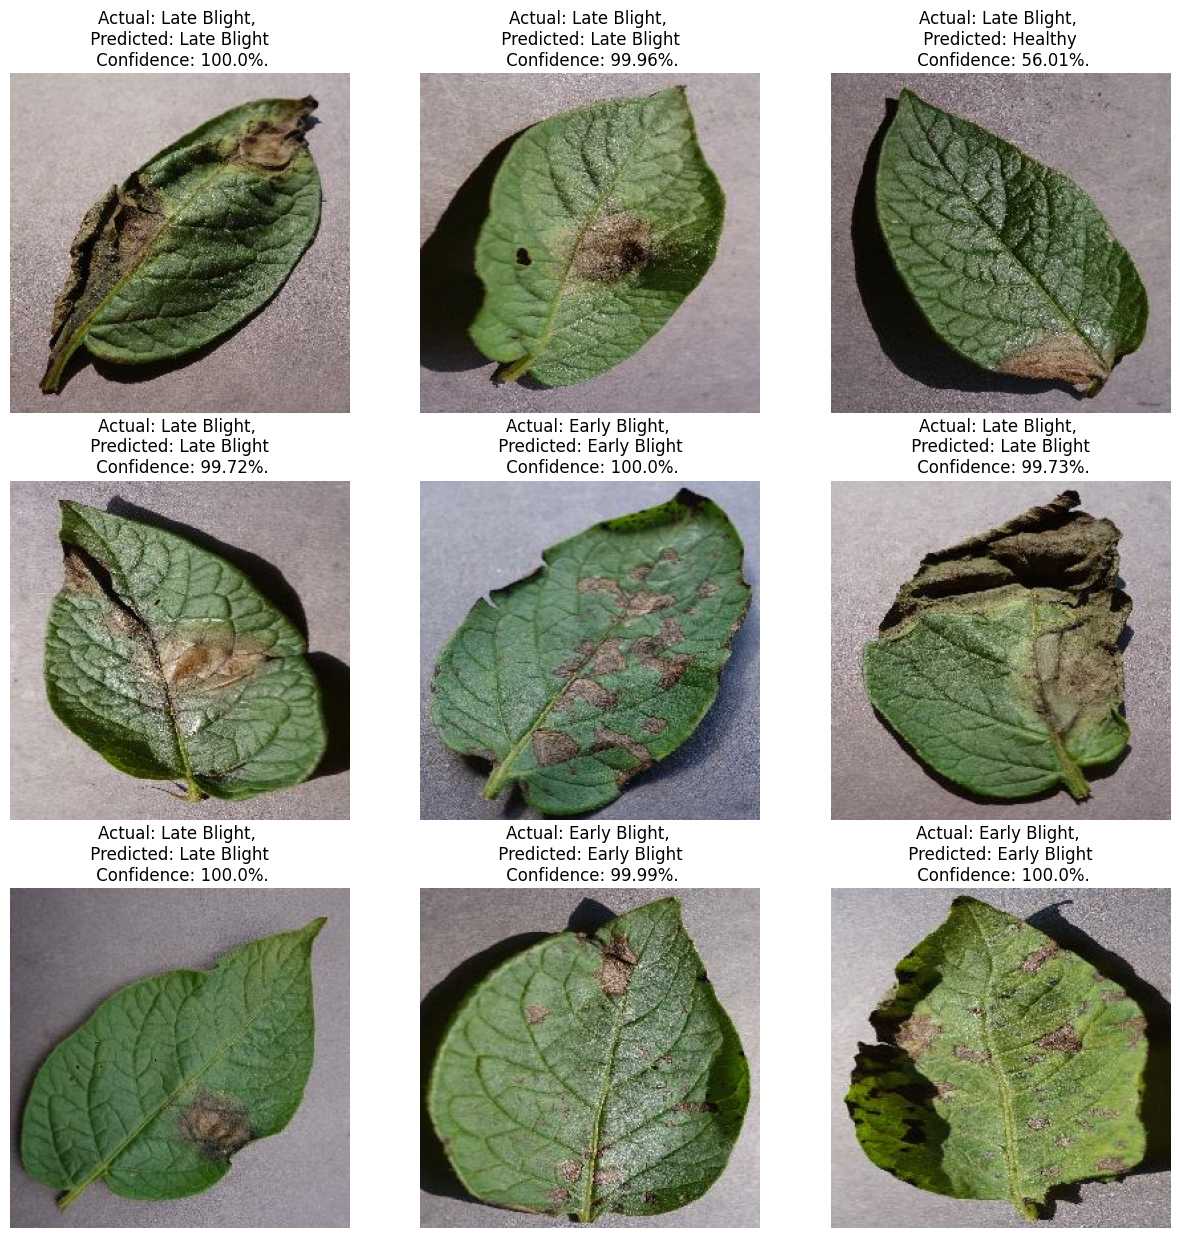

In [56]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}%.")
        
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')

#### Saving the model in Tensorflow's SavedModel format

In [58]:
model.save('../models/dira_tf_model')

INFO:tensorflow:Assets written to: ../models/dira_tf_model\assets


INFO:tensorflow:Assets written to: ../models/dira_tf_model\assets


#### Saving the model in HDF5 format -legacy
** Use .keras instead

In [60]:
model.save('../models/dira_model.keras')